## Wavelet data generation..

In [1]:
def func(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('wavelets/train/'+cls)
  os.makedirs('wavelets/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [2]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Spectrogram generation..

In [3]:
import librosa
import matplotlib.pyplot as plt
import librosa.display


def func1(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('spectrogram/train/'+cls)
  os.makedirs('spectrogram/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [4]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Model training..

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [9]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_data('spectrogram/train')
val = get_data('spectrogram/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_49168\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [11]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [14]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
history = model.fit(x_train,y_train,epochs = 500, validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 19s 949ms/step - loss: 2.2792 - accuracy: 0.1267 - val_loss: 2.2229 - val_accuracy: 0.1650
Epoch 2/500
19/19 [==============================] - 17s 896ms/step - loss: 2.0628 - accuracy: 0.2183 - val_loss: 2.0272 - val_accuracy: 0.2725
Epoch 3/500
19/19 [==============================] - 17s 870ms/step - loss: 1.8555 - accuracy: 0.3283 - val_loss: 2.0253 - val_accuracy: 0.2900
Epoch 4/500
19/19 [==============================] - 15s 782ms/step - loss: 1.7965 - accuracy: 0.3233 - val_loss: 2.0121 - val_accuracy: 0.2900
Epoch 5/500
19/19 [==============================] - 15s 815ms/step - loss: 1.6901 - accuracy: 0.3567 - val_loss: 1.9130 - val_accuracy: 0.3225
Epoch 6/500
19/19 [==============================] - 17s 924ms/step - loss: 1.6039 - accuracy: 0.4200 - val_loss: 1.8621 - val_accuracy: 0.3375
Epoch 7/500
19/19 [==============================] - 17s 877ms/step - loss: 1.5678 - accuracy: 0.4400 - val_loss: 1.8928 - val_accuracy: 0.3475
Epoc

In [16]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history.history, open('history_500_epoch_simple.pkl','wb'))

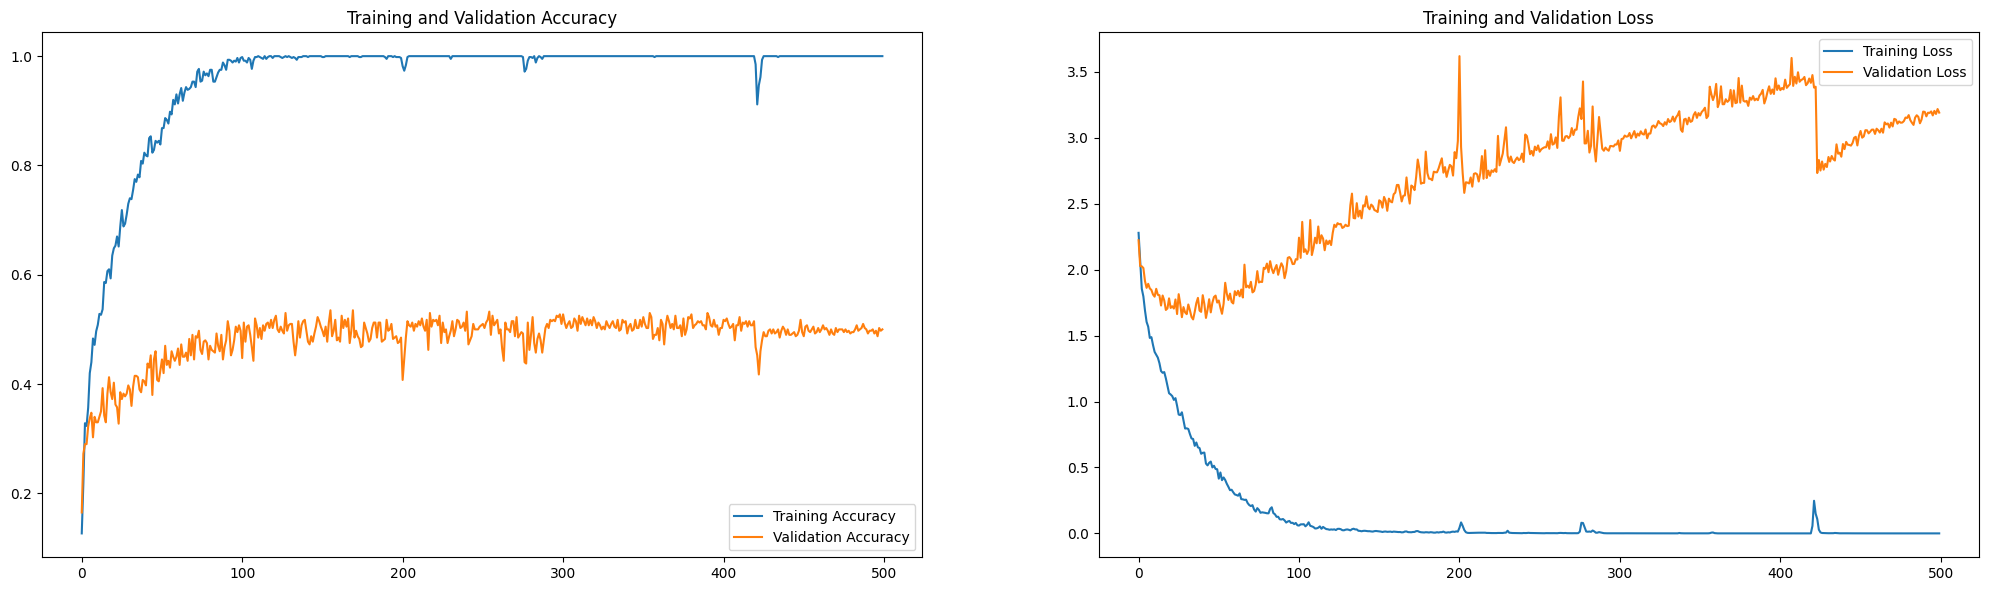

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import pickle
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('sim_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [25]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 2s 113ms/step
              precision    recall  f1-score   support

       blues       0.46      0.47      0.47        40
   classical       0.94      0.78      0.85        40
     country       0.42      0.47      0.45        40
       disco       0.39      0.42      0.40        40
      hiphop       0.42      0.55      0.47        40
        jazz       0.45      0.38      0.41        40
       metal       0.75      0.75      0.75        40
         pop       0.78      0.53      0.63        40
      reggae       0.31      0.38      0.34        40
        rock       0.31      0.28      0.29        40

    accuracy                           0.50       400
   macro avg       0.52      0.50      0.51       400
weighted avg       0.52      0.50      0.51       400



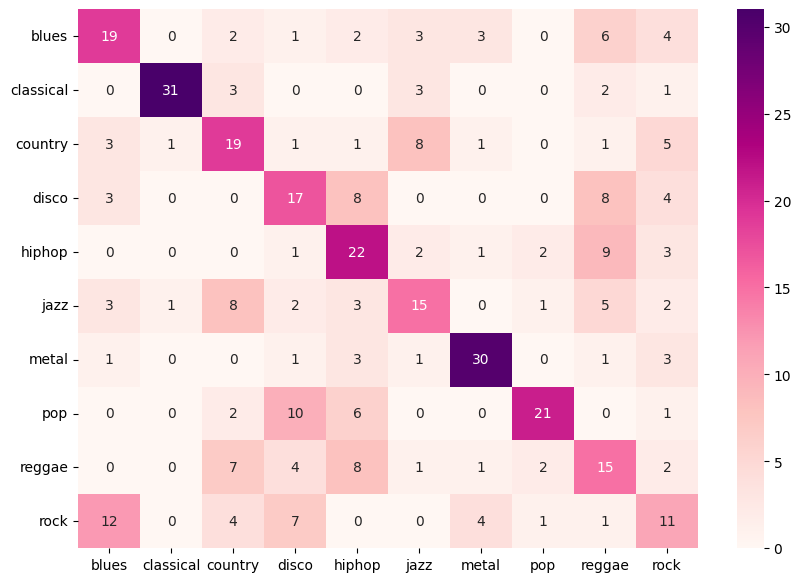

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

# Transfer Learning based modeling

In [27]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 16s 772ms/step - loss: 2.2078 - accuracy: 0.2267 - val_loss: 1.9426 - val_accuracy: 0.2775
Epoch 2/500
19/19 [==============================] - 13s 690ms/step - loss: 1.7659 - accuracy: 0.3867 - val_loss: 1.7708 - val_accuracy: 0.3425
Epoch 3/500
19/19 [==============================] - 13s 681ms/step - loss: 1.5185 - accuracy: 0.4683 - val_loss: 1.7147 - val_accuracy: 0.3550
Epoch 4/500
19/19 [==============================] - 13s 675ms/step - loss: 1.4071 - accuracy: 0.5067 - val_loss: 1.6774 - val_accuracy: 0.3150
Epoch 5/500
19/19 [==============================] - 13s 700ms/step - loss: 1.3291 - accuracy: 0.5283 - val_loss: 1.6635 - val_accuracy: 0.3575
Epoch 6/500
19/19 [==============================] - 14s 734ms/step - loss: 1.2542 - accuracy: 0.5467 - val_loss: 1.6170 - val_accuracy: 0.3325
Epoch 7/500
19/19 [==============================] - 13s 688ms/step - loss: 1.2213 - accuracy: 0.5517 - val_loss: 1.6009 - val_accuracy: 0.3600
Epoc

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
import pickle
model.save_weights('500_epoch_tr_lr.cpkt')

pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))

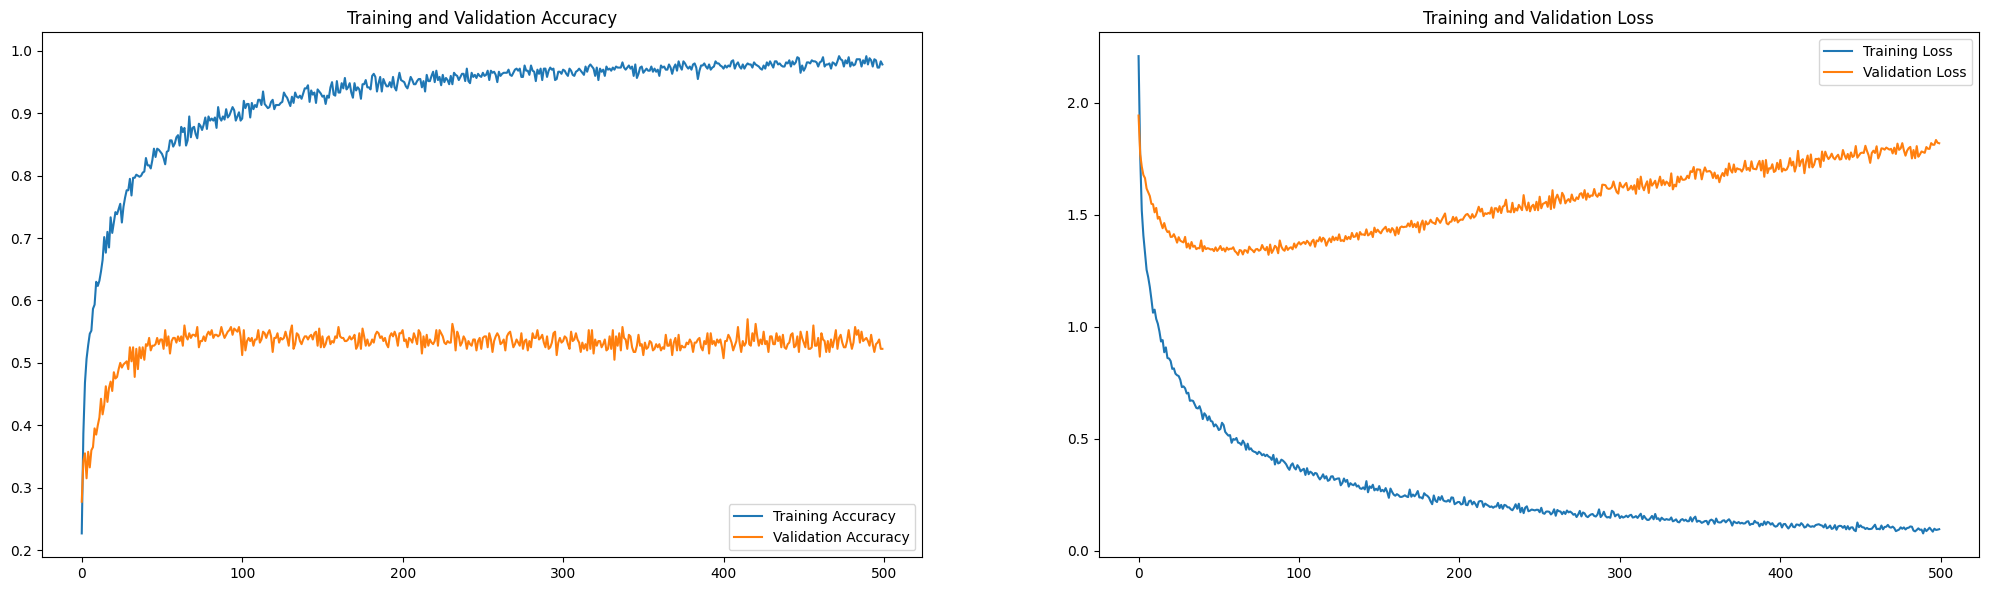

In [37]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
import pickle
history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [40]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 7s 488ms/step
              precision    recall  f1-score   support

       blues       0.45      0.57      0.51        40
   classical       0.88      0.88      0.88        40
     country       0.41      0.40      0.41        40
       disco       0.41      0.45      0.43        40
      hiphop       0.47      0.70      0.57        40
        jazz       0.75      0.68      0.71        40
       metal       0.69      0.62      0.66        40
         pop       0.76      0.70      0.73        40
      reggae       0.38      0.30      0.33        40
        rock       0.31      0.20      0.24        40

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.55      0.55      0.55       400



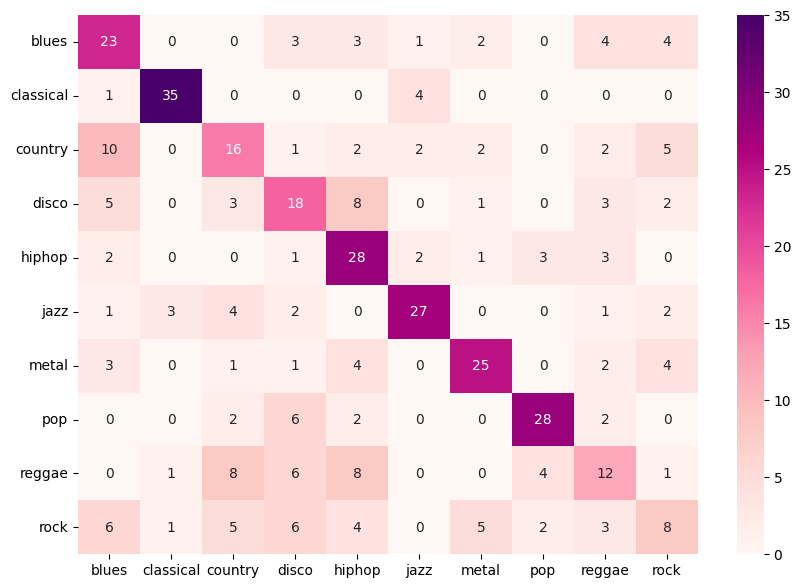

In [41]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [42]:
model.save_weights('500_epoch_transfer_lr.cpkt')
pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))


## Multi-Model Training

In [43]:
sp_train = get_data('spectrogram/train')
sp_val = get_data('spectrogram/test')

wv_train = get_data('wavelets/train')
wv_val = get_data('wavelets/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_49168\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [44]:
x_sp_train = []
y_sp_train = []
x_sp_val = []
y_sp_val = []

for feature, label in sp_train:
  x_sp_train.append(feature)
  y_sp_train.append(label)

for feature, label in sp_val:
  x_sp_val.append(feature)
  y_sp_val.append(label)

# Normalize the data
x_sp_train = np.array(x_sp_train) / 255
x_sp_val = np.array(x_sp_val) / 255

x_sp_train.reshape(-1, img_size, img_size, 1)
y_sp_train = np.array(y_sp_train)

x_sp_val.reshape(-1, img_size, img_size, 1)
y_sp_val = np.array(y_sp_val)

In [45]:
x_wv_train = []
y_wv_train = []
x_wv_val = []
y_wv_val = []

for feature, label in wv_train:
  x_wv_train.append(feature)
  y_wv_train.append(label)

for feature, label in wv_val:
  x_wv_val.append(feature)
  y_wv_val.append(label)

# Normalize the data
x_wv_train = np.array(x_wv_train) / 255
x_wv_val = np.array(x_wv_val) / 255

x_wv_train.reshape(-1, img_size, img_size, 1)
y_wv_train = np.array(y_wv_train)

x_wv_val.reshape(-1, img_size, img_size, 1)
y_wv_val = np.array(y_wv_val)

In [46]:
datagen_sp = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_sp.fit(x_sp_train)

datagen_wv = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_wv.fit(x_wv_train)

In [47]:
input_sp = keras.Input(shape=(256,256,3))
input_wv = keras.Input(shape=(256,256,3))

x = Conv2D(32,3,padding="same", activation="relu")(input_sp)
x = MaxPool2D()(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPool2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128,activation="relu")(x)
x = keras.Model(inputs=input_sp, outputs=x)

y = Conv2D(32,3,padding="same", activation="relu")(input_wv)
y = MaxPool2D()(y)
y = Conv2D(64, 3, padding="same", activation="relu")(y)
y = MaxPool2D()(y)
y = Dropout(0.4)(y)
y = Flatten()(y)
y = Dense(128,activation="relu")(y)
y = keras.Model(inputs=input_wv, outputs=y)

from tensorflow.keras.layers import concatenate
combined = concatenate([x.output, y.output])

z = Dense(32, activation="relu")(combined)
z = Dense(10, activation="softmax")(z)

model = keras.Model(inputs=[x.input, y.input], outputs=z)

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                           

In [49]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [59]:
history2 = model.fit([x_sp_train,x_wv_train],y_sp_train,epochs = 500, validation_data = ([x_sp_val,x_wv_val], y_sp_val))
import pickle
model.save_weights('500_epoch_multi_lr.cpkt')
pickle.dump(history2.history, open('history_500_epoch_multi.pkl','wb'))

Epoch 1/500
19/19 [==============================] - 31s 2s/step - loss: 9.8415e-05 - accuracy: 1.0000 - val_loss: 5.5645 - val_accuracy: 0.3300
Epoch 2/500
19/19 [==============================] - 30s 2s/step - loss: 6.8769e-05 - accuracy: 1.0000 - val_loss: 5.4828 - val_accuracy: 0.3275
Epoch 3/500
19/19 [==============================] - 30s 2s/step - loss: 6.8730e-05 - accuracy: 1.0000 - val_loss: 5.5006 - val_accuracy: 0.3250
Epoch 4/500
19/19 [==============================] - 30s 2s/step - loss: 7.9018e-05 - accuracy: 1.0000 - val_loss: 5.4960 - val_accuracy: 0.3300
Epoch 5/500
19/19 [==============================] - 31s 2s/step - loss: 7.1976e-05 - accuracy: 1.0000 - val_loss: 5.5196 - val_accuracy: 0.3300
Epoch 6/500
19/19 [==============================] - 30s 2s/step - loss: 6.3399e-05 - accuracy: 1.0000 - val_loss: 5.5341 - val_accuracy: 0.3300
Epoch 7/500
19/19 [==============================] - 30s 2s/step - loss: 5.9467e-05 - accuracy: 1.0000 - val_loss: 5.5392 - val_ac

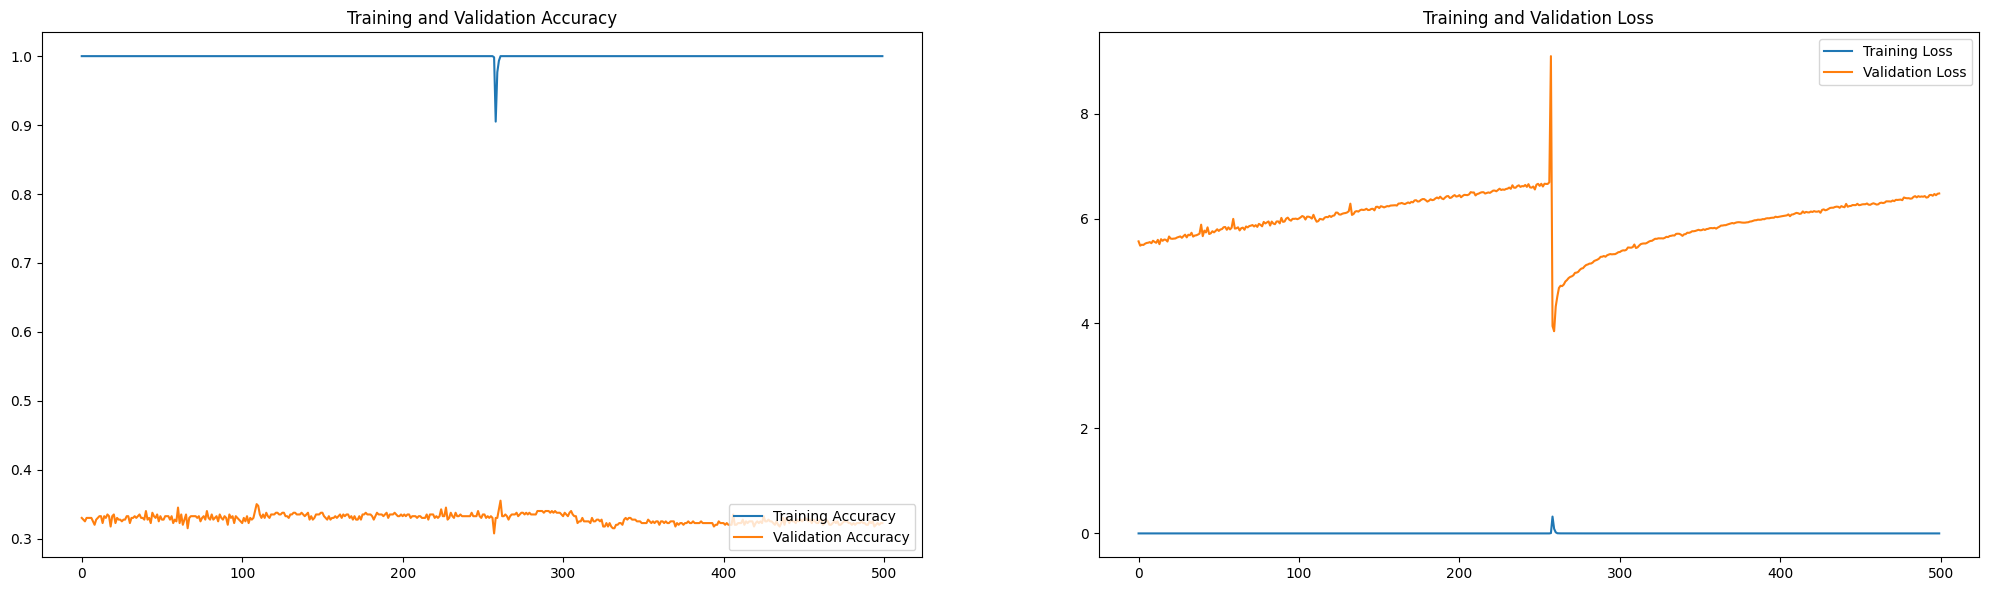

In [60]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
import pickle
history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('multi_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [62]:
predictions = model.predict([x_sp_val,x_wv_val])
print(classification_report(y_wv_val, np.argmax(predictions, axis=1), target_names = labels))

13/13 [==============================] - 3s 222ms/step
              precision    recall  f1-score   support

       blues       0.15      0.17      0.16        40
   classical       0.60      0.53      0.56        40
     country       0.19      0.20      0.20        40
       disco       0.28      0.17      0.22        40
      hiphop       0.24      0.30      0.27        40
        jazz       0.33      0.35      0.34        40
       metal       0.43      0.65      0.51        40
         pop       0.59      0.55      0.57        40
      reggae       0.21      0.20      0.20        40
        rock       0.17      0.10      0.12        40

    accuracy                           0.32       400
   macro avg       0.32      0.32      0.32       400
weighted avg       0.32      0.32      0.32       400



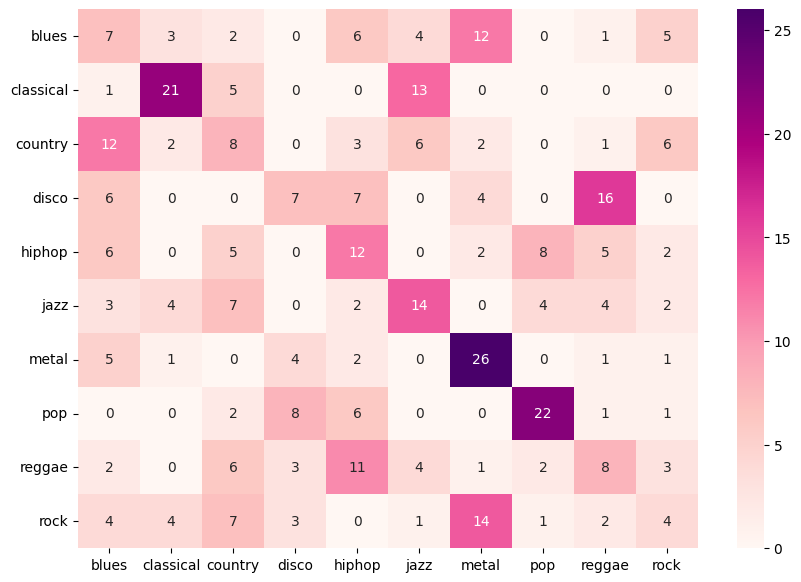

In [63]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
predictions = np.argmax(predictions, axis=1)
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')

In [64]:
epochs_range = range(500)
import matplotlib.pyplot as plt
import pickle 
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc1 = history['accuracy']
val_acc1 = history['val_accuracy']
loss1 = history['loss']
val_loss1 = history['val_loss']

history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc2 = history['accuracy']
val_acc2 = history['val_accuracy']
loss2 = history['loss']
val_loss2 = history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot(epochs_range, acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot(epochs_range, val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)
ax1.plot(epochs_range, acc2, label='Multi modal Training Accuracy', c = '#171c1c', linewid
ax1.plot(epochs_range, val_acc2, label='Multi modal Validation Accuracy', c='#62176e', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot(epochs_range, loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot(epochs_range, val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)
ax2.plot(epochs_range, loss2, label='Multi modal Training Loss',c = '#171c1c', linewidth=4)
ax2.plot(epochs_range, val_loss2, label='Multi modal learning Validation Loss', c='#62176e', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('all_1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>